In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
from sklearn.metrics import f1_score

from DecisionTree import DecisionTree

In [3]:
data_train = pd.read_csv('data/spam/spam.train', delimiter=' ', header=None).values
data_train, target_train = data_train[:, 1:], data_train[:, 0]
data_test = pd.read_csv('data/spam/spam.test', delimiter=' ', header=None).values
data_test, target_test = data_test[:, 1:], data_test[:, 0]

In [4]:
X = pd.read_csv('data/iris/iris.data', header=None).values
y = X[:, -1]
X = X[:, :-1]

# CART with kNN on leaves

In [5]:
import time

In [6]:
# _time = time.clock()
# max_depth = 10
# results = np.empty((max_depth, 2, data_test.shape[0]))
# for depth in range(1, max_depth + 1):
#     clf_skl = DecisionTreeClassifier(max_depth=depth)
#     clf_skl.fit(data_train, target_train)
#     results[depth - 1, 0, :] = clf_skl.predict(data_test)
    
#     clf = DecisionTree(max_depth=depth)
#     clf.fit(data_train, target_train)
#     results[depth - 1, 1, :] = clf.predict(data_test)
    
# print("Elapsed:", time.clock() - _time)

In [7]:
# np.savez('results', results)
results = np.load('results.npz')['arr_0']

In [8]:
f1 = np.empty((results.shape[0], 2))
for i, result in enumerate(results):
    f1[i, 0] = f1_score(target_test, result[0])
    f1[i, 1] = f1_score(target_test, result[1])

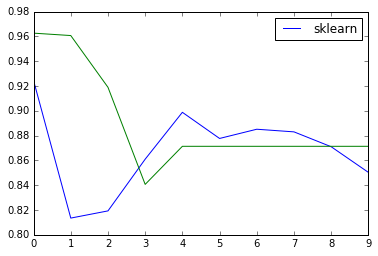

In [9]:
plt.plot(f1[:, 0], label='sklearn')
plt.plot(f1[:, 1])
plt.legend()
plt.show()